## Import

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.timeseries import LombScargle
import os
os.environ['JAX_PLATFORM_NAME'] = 'cpu' 
from scipy.stats import norm, linregress
#from gpyrn import covfunc, meanfunc, meanfield
import exoplanet as xo
from scipy.optimize import minimize
from scipy.stats import norm
import csv
from scipy import stats
from multiprocessing import Pool
import emcee
import corner
from loguniform import LogUniform, ModifiedLogUniform
import sys
sys.path.append(os.path.abspath("/home/paul/Bureau/IRAP/TediGP"))
import process, kernels, means
from scipy import signal
from tqdm import tqdm
import pandas as pd
from scipy.stats.stats import pearsonr 

np.random.seed(110**2)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


## Load 2 first componant

In [2]:
eigen2vectors = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesAU_MIC/2firstcomponent.npy', allow_pickle=True) #### PATH TO CHANGE ####
times = np.load('/home/paul/Bureau/IRAP/dLWPCA/out/TablesAU_MIC/readyforwPCA_epoc.npy')                          #### PATH TO CHANGE ####

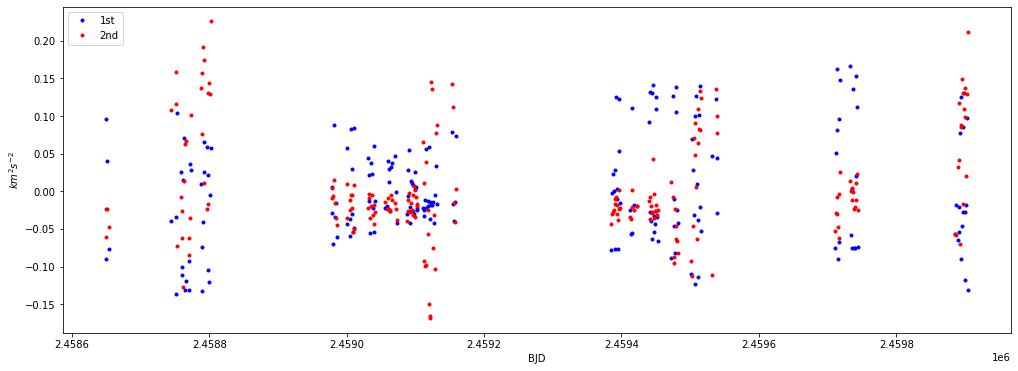

In [3]:
plt.figure(figsize=(17, 6))
plt.plot(times, eigen2vectors[0], 'b.', label='1st')
plt.plot(times, eigen2vectors[1], 'r.', label='2nd')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
#plt.plot(times[:-1], eigen2vectors[3], 'r.')

plt.show()

## Periodograms
### 1st component

Peak frequency = 
4.872134347020897


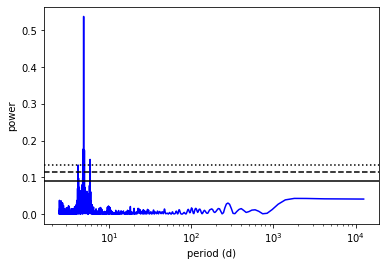

In [4]:
frequency, power = LombScargle(times, eigen2vectors[0]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'b')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[0])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

Very strong Peak at $P_{rot}$

### 2nd component

Peak frequency = 
358.7282917792244


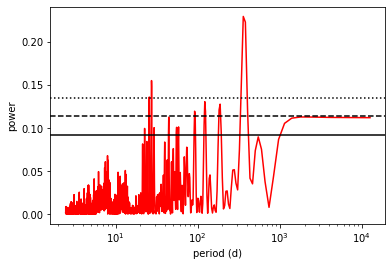

In [5]:
frequency, power = LombScargle(times, eigen2vectors[1]).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times, eigen2vectors[1])

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

## First component GP

Just to recall the GP uses a Quasi-Periodic covariance function that is build that way:


$K_{ij} = \eta_1^2 \, \exp \left[- \frac{(t_i - t_j)^2}{2 \eta_2^2} - \frac{2 }{\eta_4^2} \sin^2 \left( \frac{\pi (t_i - t_j)}{\eta_3} \right) \right] + Jitter$ 

In [6]:
print(2*(np.max(eigen2vectors[0])- np.min(eigen2vectors[0])))
print(np.std(eigen2vectors[0]))
print(10*(np.max(times)-np.min(times)))


0.6068144775809226
0.07001222336212883
12555.490212272853


For the Prior distribution, I use : 

$\eta_1 : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

$\eta_2 : \mathcal{LU}\left( 1 , 10 \times t_{total} \right)$

$\eta_3 : \mathcal{N}\left( P , 0.1 \right)$

$\eta_4 : \mathcal{LU}\left( 0.1, 5 \right)$

$Jitter : \mathcal{MLU}\left( y_\sigma , 2 \times y_{ptp} \right)$

In [7]:
#Priors
n_eta1 = ModifiedLogUniform(0.07, 0.6)
n_eta2 = stats.loguniform(1, 565)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.07, 0.6)

In [8]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

In [9]:
def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0], yerr = 1e-12 * np.identity(times.size))
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [10]:
ndim = priors().size 
nwalkers = 2*ndim

In [12]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [06:24<00:00, 26.03it/s]


State([[7.61416965e-02 1.63772823e+02 4.86276159e+00 9.03930183e-01
  7.66112233e-03]
 [6.58363042e-02 1.50103850e+02 4.85907864e+00 8.18521014e-01
  7.14995169e-03]
 [7.23378542e-02 1.44064392e+02 4.85957828e+00 8.99406734e-01
  7.60670803e-03]
 [7.07780884e-02 1.24697250e+02 4.86108357e+00 9.69602585e-01
  7.39228164e-03]
 [7.21303358e-02 1.52487552e+02 4.86455187e+00 8.73568987e-01
  7.18301415e-03]
 [5.09591304e-02 1.36609221e+02 4.85941897e+00 7.88296197e-01
  8.08765186e-03]
 [8.95471706e-02 1.70787600e+02 4.86317089e+00 9.22926435e-01
  7.69192850e-03]
 [7.60317988e-02 1.46697061e+02 4.86065515e+00 9.97468706e-01
  7.53681892e-03]
 [7.77006018e-02 1.77645353e+02 4.86425652e+00 8.67430885e-01
  7.78512603e-03]
 [6.22805464e-02 1.59210837e+02 4.85799576e+00 7.89262494e-01
  6.65568021e-03]], log_prob=[560.76632639 559.45213202 560.21041877 558.04320674 560.06783946
 556.38925725 559.16391474 559.44203806 558.92351387 554.62270945], blobs=None, random_state=('MT19937', array([16756

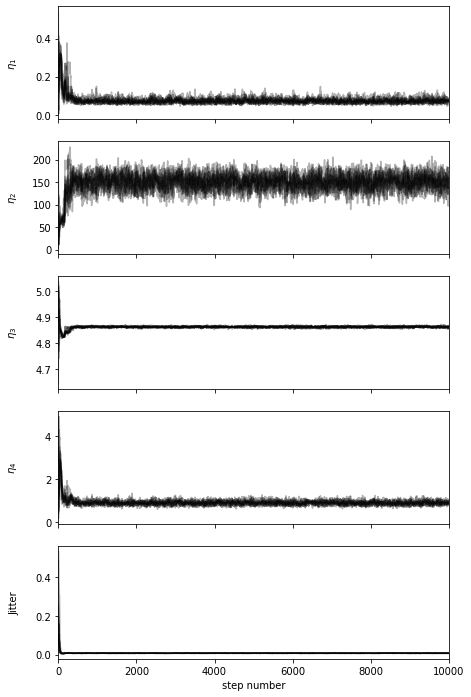

In [13]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

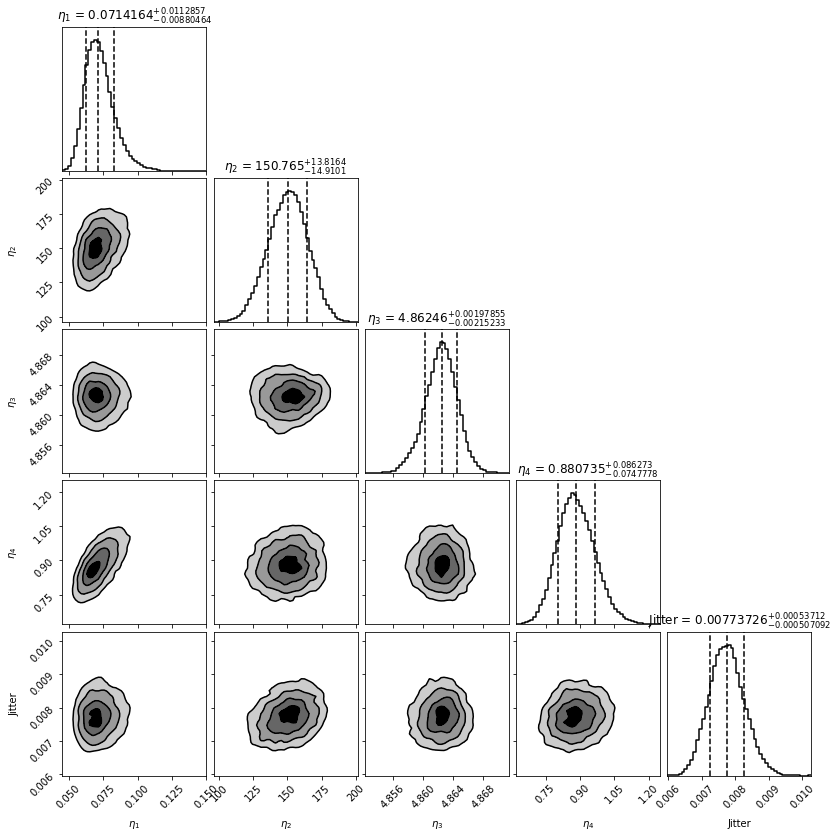

In [14]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

In [15]:
# Best Fit
ind_mlh = np.argmax([logPosterior(flat_samples[i]) for i in tqdm(range(len(flat_samples)))])
sample_mlh = flat_samples[ind_mlh]
print('Best Fit', sample_mlh, logPosterior(sample_mlh))

100%|██████████| 6330/6330 [00:22<00:00, 283.44it/s]

Best Fit [6.65711705e-02 1.48361988e+02 4.86222215e+00 8.65276018e-01
 7.59134846e-03] 561.2554871508439


$\eta_2$ and $\eta_3$ compatible with $<B>$ GP results from Donati et al. (2023, submitted)

$\eta_4$ compatible with $B_l$ GP results from Donati et al. (2023, submitted)

In [16]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(eigen2vectors[0]))
    gpOBJ = process.GP(kernel,mean,times,eigen2vectors[0],yerr = 1e-12 * np.identity(times.size))
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

In [17]:
tplot = np.linspace(2.4585e6, 2.46e6, 2000)

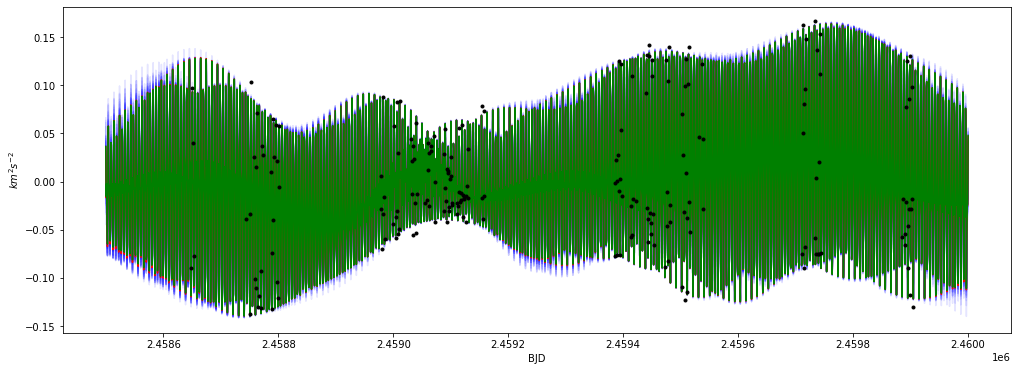

In [19]:
plt.figure(figsize=(17, 6))

for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
GPca = Display(Hfit, tplot)
BestFitPCA = Display(sample_mlh, tplot)
plt.plot(tplot, GPca, 'r')
plt.plot(tplot, BestFitPCA, 'g')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

In [20]:
print('logLikelihood:', logPosterior(Hfit))

logLikelihood: 561.2135899846771


100%|██████████| 15/15 [00:02<00:00,  5.72it/s]


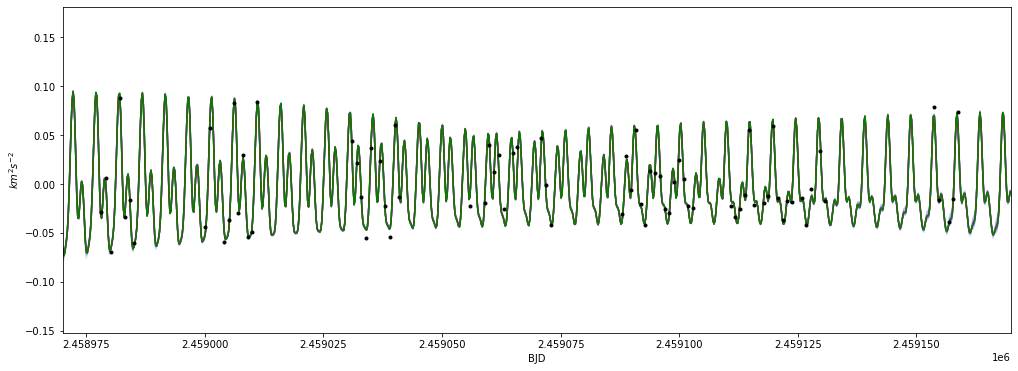

In [21]:
plt.figure(figsize=(17, 6))
tplot2 = np.linspace(-30+2459000, 170+2459000, 1000)

for s in tqdm(range(15)):
    plt.plot(tplot2, Display(flat_samples[s,:], tplot2), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot2, Display(Hfit, tplot2), 'r')
plt.plot(tplot2, Display(sample_mlh, tplot2), 'g')
plt.plot(times, eigen2vectors[0],'k.')
plt.xlim([-30+2459000, 170+2459000])
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

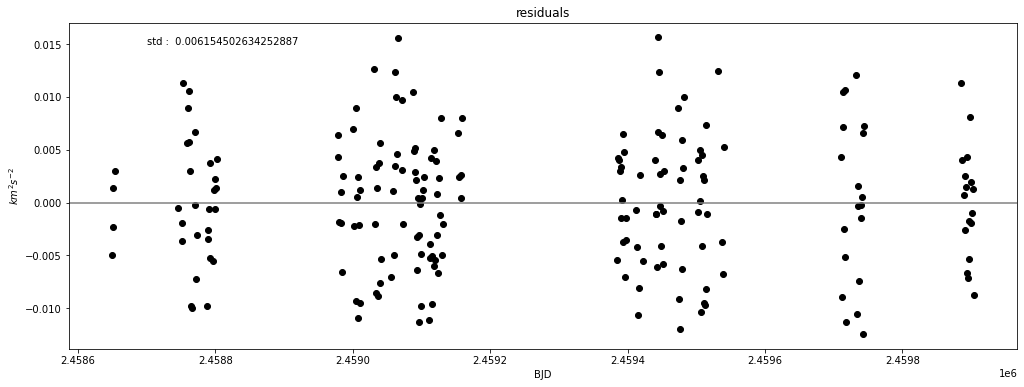

In [22]:
y_sample = Display(sample_mlh, times)

residuals = eigen2vectors[0] - y_sample
plt.figure(figsize=(17, 6))
plt.plot(times, residuals, 'ok')
plt.axhline(y=0, c='grey')
plt.annotate( "std :  " + str(np.std(residuals)), (2.4587*1e6, 0.015) )
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$km^2 s^{-2}$')
plt.show()

# Compares with Donati et al. (submitted)
## Load Data

## Magnetic Field B

In [23]:
B_table = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/B.txt')


times_pca = times 
times_B = B_table[:,0] + 2459000
B = B_table[:,1]
dB = B_table[:,2]

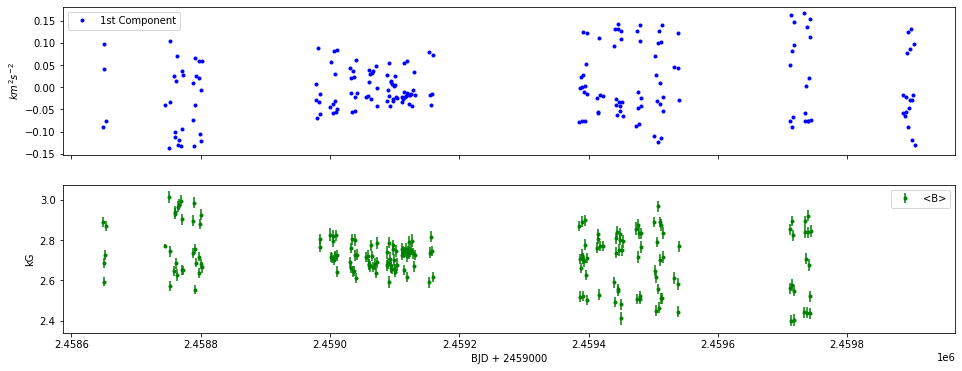

In [24]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
plt.plot(times_pca, eigen2vectors[0], 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)


# share x and y
ax3 = plt.subplot(212, sharex=ax1)
plt.errorbar(times_B, B, yerr=dB, fmt='.g', label='<B>')
plt.xlabel('BJD + 2459000')
plt.ylabel('kG')
plt.legend()
plt.show()


Peak frequency = 
4.872610970181846


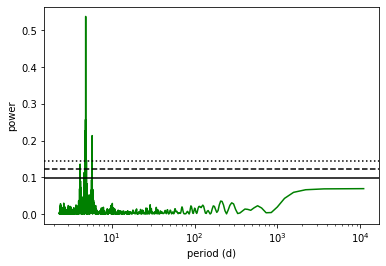

In [25]:
frequency, power = LombScargle(times_B, B).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'g')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_B, B)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

###  B GP

In [26]:
print(2*(np.max(B)- np.min(B)))
print(np.std(B))
print(10*(np.max(times_B)-np.min(times_B)))

1.2224000000000004
0.12771711650555842
10948.756849998608


In [27]:
#Priors
n_eta1 = ModifiedLogUniform(0.12, 1.2)
n_eta2 = stats.loguniform(1, 11000)
n_eta3 = stats.norm(loc=4.865, scale=0.1)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.12, 1.2)

In [28]:
def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(B))
    gpOBJ = process.GP(kernel,mean,times_B,B, yerr = dB)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior

In [29]:
ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 10000, progress=True)

100%|██████████| 10000/10000 [05:19<00:00, 31.26it/s]


State([[1.98733752e-01 1.47662126e+02 4.85912726e+00 1.68309167e+00
  8.75222212e-03]
 [2.26426976e-01 1.77384999e+02 4.86150450e+00 1.66484275e+00
  8.94366058e-03]
 [1.45857855e-01 1.72397028e+02 4.86126451e+00 1.27879609e+00
  4.18035793e-03]
 [1.71016812e-01 1.34155984e+02 4.86324745e+00 1.48886728e+00
  2.42488578e-03]
 [1.29979213e-01 1.39007288e+02 4.85813815e+00 1.25643110e+00
  3.17131446e-03]
 [2.42674863e-01 1.56890087e+02 4.86286610e+00 1.81468484e+00
  7.12254527e-04]
 [1.69977291e-01 1.71032508e+02 4.85650939e+00 1.50887997e+00
  9.33234415e-03]
 [1.46987177e-01 2.04779439e+02 4.86295645e+00 1.15374161e+00
  1.63224494e-02]
 [1.99805177e-01 1.59158061e+02 4.85816422e+00 1.59852633e+00
  5.46644411e-03]
 [1.90555617e-01 1.17887831e+02 4.86994646e+00 1.37637182e+00
  6.32841926e-03]], log_prob=[327.33926242 326.63416955 328.61050834 328.0412535  329.16833298
 326.26455871 327.54174642 325.5047739  328.00169854 322.1708356 ], blobs=None, random_state=('MT19937', array([16756

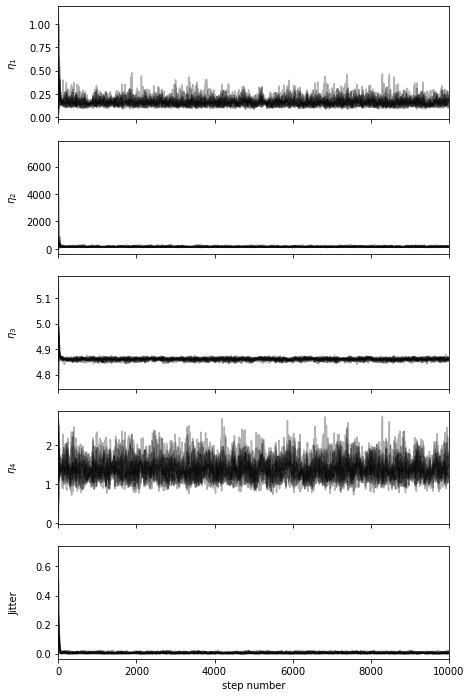

In [30]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

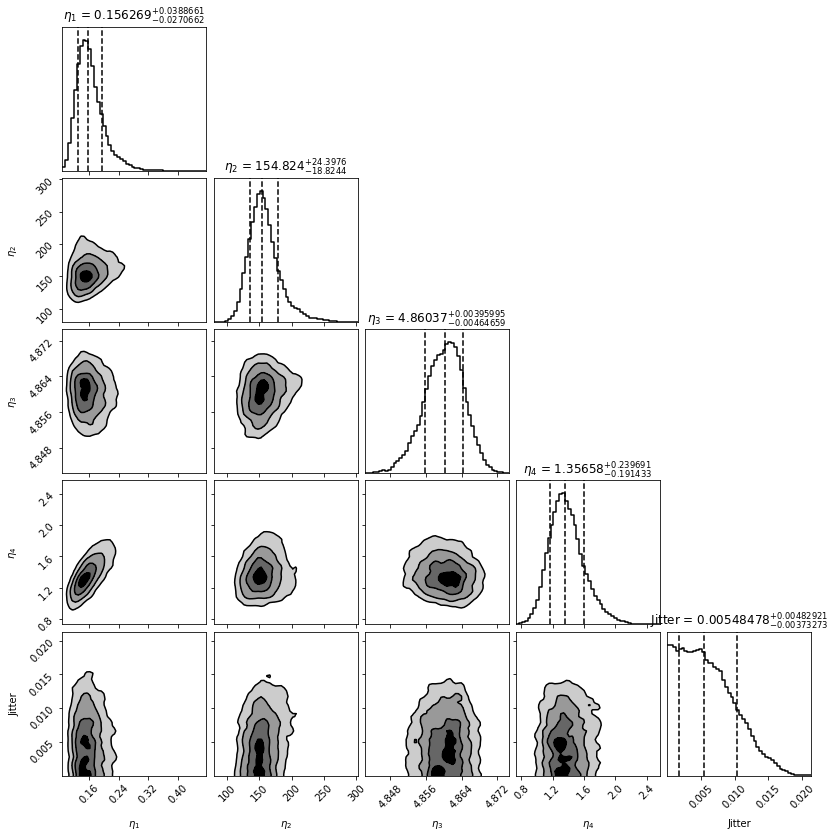

In [31]:
#corner plot
flat_samples = sampler.get_chain(discard=500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

In [32]:
# Best Fit
ind_mlh = np.argmax([logPosterior(flat_samples[i]) for i in tqdm(range(len(flat_samples)))])
sample_mlh = flat_samples[ind_mlh]
print('Best Fit', sample_mlh, logPosterior(sample_mlh))

100%|██████████| 6330/6330 [00:21<00:00, 297.95it/s]

Best Fit [1.44560130e-01 1.49750172e+02 4.85986678e+00 1.28248059e+00
 5.91764874e-04] 329.52339934562866


#### On retrouve l'exact même résultat que Donati et al. (Submitted) ! 

In [33]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(B))
    gpOBJ = process.GP(kernel,mean,times_B,B,yerr = dB)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

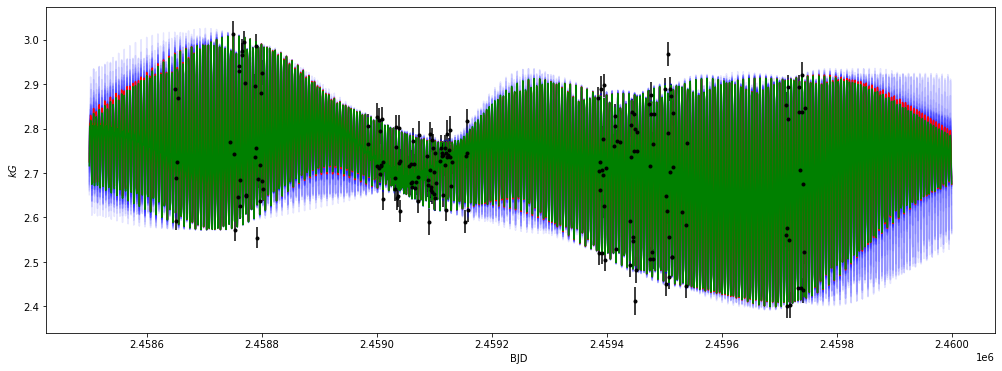

In [34]:
plt.figure(figsize=(17, 6))


for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
GPb = Display(Hfit, tplot)
plt.plot(tplot, GPb, 'r')
BestFitB = Display(sample_mlh, tplot)
plt.plot(tplot, BestFitB, 'g')
plt.errorbar(times_B, B, yerr=dB, fmt='k.')
plt.xlabel('BJD ')
plt.ylabel('$kG$')
plt.show()

In [35]:
print('logLikelihood:', logPosterior(Hfit))

logLikelihood: 329.27182718404777


100%|██████████| 15/15 [00:02<00:00,  7.12it/s]


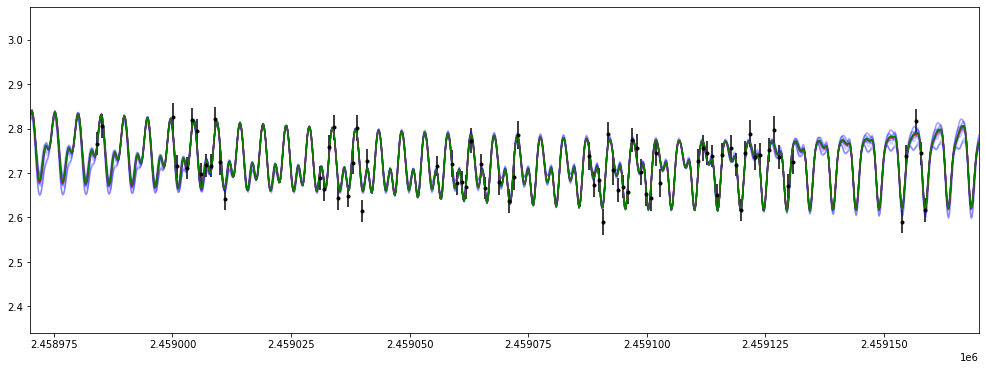

In [36]:
plt.figure(figsize=(17, 6))

tplot2 = np.linspace(-30+ 2459000,170+ 2459000, 1000)
 
for s in tqdm(range(15)):
    plt.plot(tplot2, Display(flat_samples[s,:], tplot2), 'b', alpha=0.2)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot2, Display(Hfit, tplot2), 'r')
plt.plot(tplot2, Display(sample_mlh, tplot2), 'g')
plt.errorbar(times_B, B, yerr=dB, fmt='k.')
plt.xlim([-30 + 2459000,170 + 2459000])
plt.show()

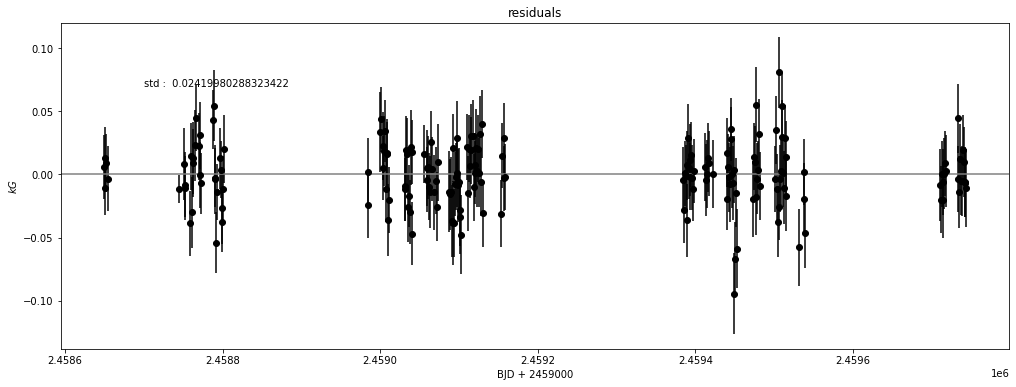

In [37]:
y_sample = Display(Hfit, times_B)

residuals = B - y_sample
plt.figure(figsize=(17, 6))
plt.errorbar(times_B, residuals, yerr=dB, fmt='ok')
plt.annotate( "std :  " + str(np.std(residuals)), (+ 2459000 -300, 0.07) )
plt.axhline(y=0, c='grey')
plt.title('residuals')
plt.xlabel('BJD + 2459000')
plt.ylabel('$kG$')
plt.show()

### Correlation Coef Between W1 and B

In [38]:
def reshapetocorr(t1, d1, t2, d2, dd1 = None, dd2 = None, verbose = False):

    i, j = 0, 0
    D1 = np.copy(d1)
    T1 = np.copy(t1)
    D2 = np.copy(d2)
    T2 = np.copy(t2)
    if dd1 is not None:
        dD1 = np.copy(dd1)
    if dd2 is not None:
        dD2 = np.copy(dd2)
    while i < len(T1) and j < len(T2):
        diff = T1[i] - T2[j]
        if np.abs(diff) < 0.5:
            i += 1
            j += 1
        elif diff > 0.5:
            if verbose :
                print('L', T1[i], 'R', T2[j])
                print('point remove R')
            T2 = np.delete(T2, j)
            D2 = np.delete(D2, j)
            if dd2 is not None:
                dD2 = np.delete(dD2, j)
        elif diff < -0.5:
            if verbose :
                print('L', T1[i], 'R', T2[j])
                print('point remove L')
            T1 = np.delete(T1, i)
            D1 = np.delete(D1, i)
            if dd1 is not None:
                dD1 = np.delete(dD1, j)
        
    T1 = T1[:i]
    D1 = D1[:i]
    T2 = T2[:j]
    D2 = D2[:j]
    if dd1 is not None:
        dD1 = dD1[:j]
    if dd2 is not None:
        dD2 = dD2[:j]
    if dd1 is None:
        dD1 = None
    if dd2 is None:
        dD2 = None
    
    return(T1, D1, T2, D2, dD1, dD2)

In [39]:
twcorr, wcorr, tbcorr, bcorr, __, dbcorr = reshapetocorr(times, eigen2vectors[0], times_B, B, dd2 = dB)

In [40]:
print(twcorr - tbcorr)

[-1.62641518e-05 -6.37955964e-07 -2.18534842e-06 -9.91672277e-06
 -3.01459804e-05  3.72249633e-05  2.31489539e-05 -6.70570880e-05
  1.40783377e-05 -9.35122371e-05  5.81649132e-04 -4.36706468e-05
  8.19917768e-05  1.52410939e-05  8.87410715e-06 -5.38970344e-05
  5.72865829e-05 -1.21421181e-05  1.74997374e-04  2.58564018e-04
  1.15652103e-04 -1.44144055e-04  9.28668305e-06  5.20129688e-05
 -5.71054406e-05  3.67905013e-05 -1.12599228e-04 -5.46304509e-05
  3.10903415e-05 -1.18381809e-04  1.00472942e-04 -3.52747738e-05
 -3.92240472e-05 -6.75814226e-06  7.04638660e-06 -5.16069122e-05
  5.40390611e-05  1.11912377e-05  7.28294253e-06 -8.42991285e-05
  7.29202293e-05  1.36968074e-03 -6.95735216e-05 -3.81655991e-06
 -5.95953315e-06 -2.48602591e-05 -5.97150065e-05 -3.17236409e-05
  3.94643284e-05 -4.63332981e-05 -1.21722929e-04  7.02161342e-05
  1.05146319e-06  3.44053842e-05  2.82581896e-05  6.19390048e-05
  9.62861814e-05  1.70399435e-05  1.74106099e-05  1.46385282e-05
  1.75661407e-05 -2.77481

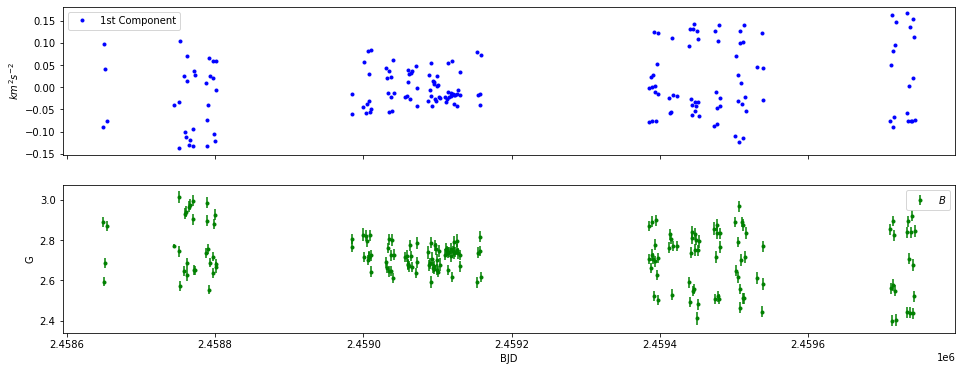

In [41]:
plt.figure(figsize=(16, 6))
ax1 = plt.subplot(211)
plt.plot(twcorr, wcorr, 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)


# share x and y
ax3 = plt.subplot(212, sharex=ax1)
plt.errorbar(tbcorr, bcorr, yerr=dbcorr, fmt='.g', label='$B$')
plt.xlabel('BJD')
plt.ylabel('G')
plt.legend()
plt.show()

In [42]:
pearsonr(bcorr, wcorr)

(-0.9602252378428018, 1.1570364985953769e-101)

R = 0.97 Donati et al (2023, submitted)

### Correlation between GPs of W1 and B

In [43]:
pearsonr(GPca, GPb)
pearsonr(BestFitPCA, BestFitB)

(-0.9415195736505635, 0.0)

## Comparison /w RVs 

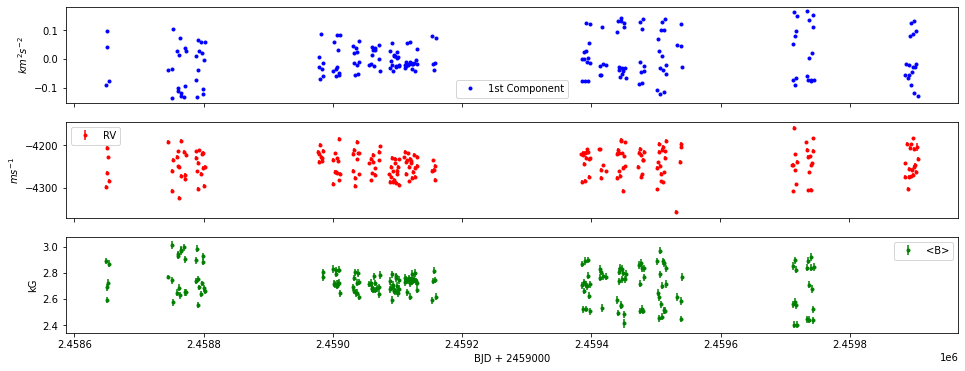

In [44]:
times_RV, RV, dRV = np.loadtxt('/media/paul/One Touch2/SPIRou_Data/AU_MIC/lbl2_AUMIC_AUMIC.rdb',
                   usecols=(0,1,2),skiprows=2, dtype=str, unpack=True)

times_RV = np.array(times_RV.astype(float)) + 2.4e6
RV = np.array(RV.astype(float))
dRV = np.array(dRV.astype(float))

# Remove an obsvious outlier
index_outlier = np.argmax(dRV)
times_RV = np.delete(times_RV, index_outlier)
RV = np.delete(RV, index_outlier)
dRV = np.delete(dRV, index_outlier)


plt.figure(figsize=(16, 6))
ax1 = plt.subplot(311)
plt.plot(times_pca, eigen2vectors[0], 'b.', label='1st Component')
plt.ylabel('$km^2 s^{-2}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

ax2 = plt.subplot(312)
plt.errorbar(times_RV, RV, yerr = dRV, fmt='r.', label='RV')
plt.ylabel('$m s^{-1}$')
plt.legend()
plt.tick_params('x', labelbottom=False)

# share x and y
ax3 = plt.subplot(313, sharex=ax1)
plt.errorbar(times_B, B, yerr=dB, fmt='.g', label='<B>')
plt.xlabel('BJD + 2459000')
plt.ylabel('kG')
plt.legend()
plt.show()

Peak frequency = 
4.872250163692226


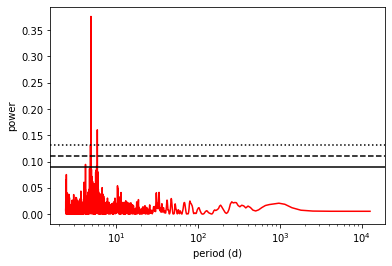

In [45]:
frequency, power = LombScargle(times_RV, RV, dRV).autopower()
plt.figure(2)
plt.plot(1/frequency, power, 'r')
plt.xlabel("period (d)")
plt.ylabel("power")
plt.xscale('log')


peak_freq = 1 / frequency[np.argmax(power)]
print('Peak frequency = ')
print(peak_freq)

ls = LombScargle(times_RV, RV, dRV)

fap = ls.false_alarm_level(0.1)
plt.axhline(fap, linestyle='-', color='k')

fap = ls.false_alarm_level(0.01)
plt.axhline(fap, linestyle='--', color='k')

fap = ls.false_alarm_level(0.001)
plt.axhline(fap, linestyle=':', color='k')

plt.show()

### Simple Correlations 

In [46]:
print('RV X B :')
trvcorrb, rvcorrb, tbcorrrv, bcorrrv, drvcorrb, dbcorrrv = reshapetocorr(times_RV, RV, times_B, B, dd1 = dRV,dd2 = dB)
print(pearsonr(bcorrrv, rvcorrb))

print('RV X W1 :')
trvcorrw, rvcorrw, twcorrrv, wcorrrv, drvcorrw, dwcorrrv = reshapetocorr(times_RV, RV, times, eigen2vectors[0], dd1 = dRV)
print(pearsonr(wcorrrv, rvcorrw))

RV X B :
(0.11794960184050017, 0.10885170766180405)
RV X W1 :
(-0.09108634902802165, 0.1950877674774899)


RV X B -> R = 0.12 Donati et al. (2023, submitted)

### first derivative correlations 

In [47]:
Bp = np.gradient(B, times_B)
Wp = np.gradient(eigen2vectors[0], times)

In [48]:
print('RV X dB/dt :')
trvcorrbp, rvcorrbp, tbpcorrrv, bpcorrrv, drvcorrbp, __ = reshapetocorr(times_RV, RV, times_B, Bp, dd1 = dRV)
print(pearsonr(bpcorrrv, rvcorrbp))

print('RV X dW1/dt :')
trvcorrwp, rvcorrwp, twpcorrrv, wpcorrrv, drvcorrwp, __ = reshapetocorr(times_RV, RV, times, Wp, dd1 = dRV)
print(pearsonr(wpcorrrv, rvcorrwp))

RV X dB/dt :
(0.6863724603408872, 3.017349171587831e-27)
RV X dW1/dt :
(-0.6764523421039603, 1.2113735895729148e-28)


RV X B' -> R = 0.80 Donati et al. (2023, submitted)

### RV GP 

Note : a future work will be to add the known planets in the RV signal

In [49]:
print(2*(np.max(RV)- np.min(RV)))
print(np.std(RV))
print(10*(np.max(times_RV)-np.min(times_RV)))

393.82589078008095
31.842086602417222
12565.53317216225


In [50]:
#Priors
n_eta1 = ModifiedLogUniform(30, 400)
n_eta2 = stats.loguniform(1, 11000)
n_eta3 = stats.norm(loc=4.86, scale=0.03)
n_eta4 = stats.loguniform(0.1, 5)
jitter = ModifiedLogUniform(0.12, 32)

def priors():
    return np.array([n_eta1.rvs(),n_eta2.rvs(), n_eta3.rvs(), n_eta4.rvs(), jitter.rvs()])

def logPosterior(HyperParam):
    n1,n2,n3,n4, j = HyperParam
    
    logprior = n_eta1.logpdf(n1)
    logprior += n_eta2.logpdf(n2)
    logprior += n_eta3.logpdf(n3)
    logprior += n_eta4.logpdf(n4)
    logprior += jitter.logpdf(j)
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(RV))
    gpOBJ = process.GP(kernel,mean,times_RV,RV, yerr = dRV)
    
    logposterior = gpOBJ.log_likelihood() + logprior
    return logposterior



In [51]:
ndim = priors().size 
nwalkers = 2*ndim

sampler = emcee.EnsembleSampler(nwalkers, ndim, logPosterior)
p0=[priors() for i in range(nwalkers)]
sampler.run_mcmc(p0, 20000, progress=True)

100%|██████████| 20000/20000 [12:30<00:00, 26.64it/s]


State([[ 29.67304485 133.17557622   4.86946212   0.69773929  13.76920197]
 [ 31.39660624 143.56114882   4.86653354   0.75814811  12.69436297]
 [ 40.28739199 130.75235308   4.86875463   0.80629204  12.12057953]
 [ 33.29331437 145.25796286   4.87084766   0.58479944  13.08975872]
 [ 34.31611935 144.85231063   4.8708117    0.55954583  13.40807168]
 [ 34.33934271 148.58864758   4.86839724   0.70161309  13.17500938]
 [ 30.42265201 155.52943476   4.86467339   0.65295146  13.38281564]
 [ 32.8151393  181.62918069   4.86333539   0.62346324  12.32787711]
 [ 37.07489921 143.31929612   4.86860141   0.64238807  13.52037097]
 [ 33.89464645 148.91031244   4.86818204   0.60969797  12.66326809]], log_prob=[-932.41899442 -932.92658955 -935.67379801 -932.7226221  -933.87584121
 -932.01507614 -932.77771927 -936.81394082 -933.4973758  -931.94132563], blobs=None, random_state=('MT19937', array([ 512674516, 1786544555, 3790568258, 2199457658,  600383663,
         26866803, 1182252379, 1520685624, 2028813396, 

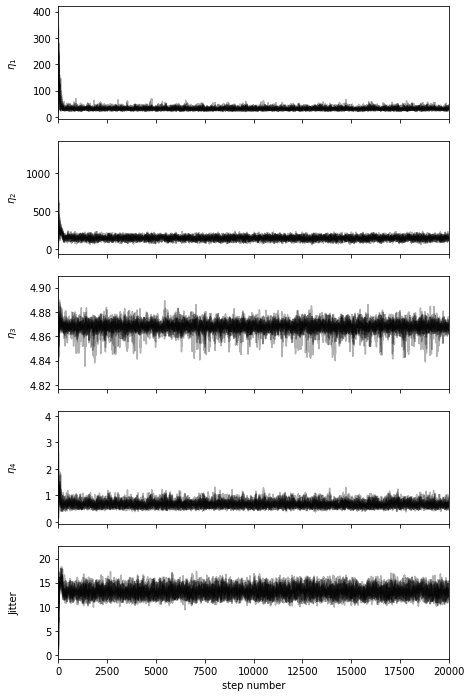

In [52]:
#chains plot
fig, axes = plt.subplots(5, figsize=(7, 12), sharex=True)
samples = sampler.get_chain()
labels = ["$\eta_1$", "$\eta_2$", "$\eta_3$", "$\eta_4$", "Jitter"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("step number");
plt.show()

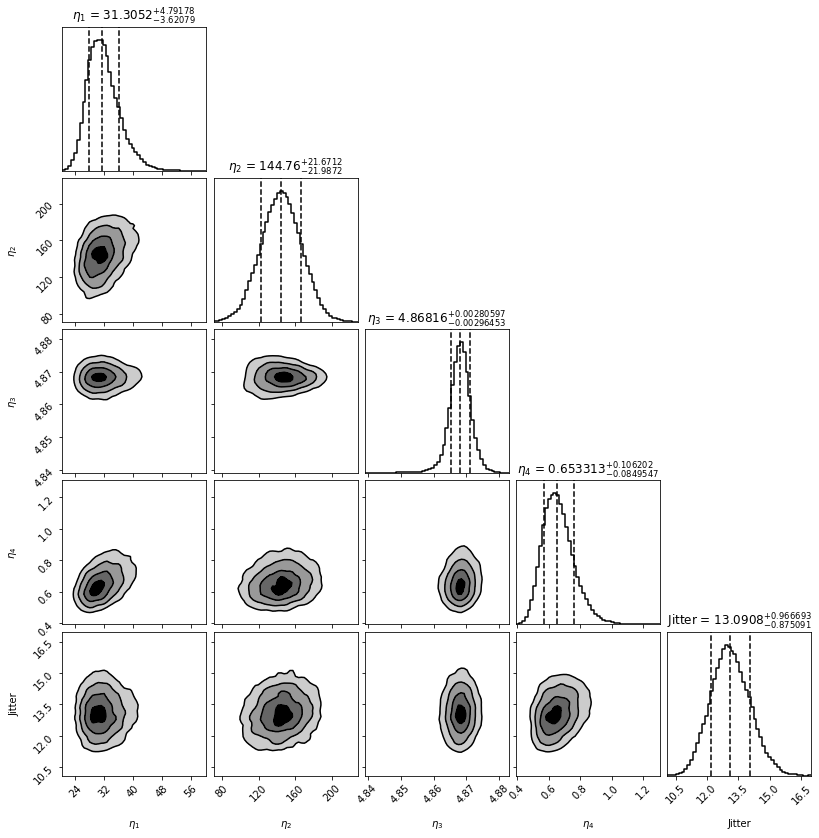

In [53]:
#corner plot
flat_samples = sampler.get_chain(discard=4500, thin=15, flat=True)
fig = corner.corner(flat_samples,labels=labels, color="k", bins = 50,
                    quantiles=[0.16, 0.5, 0.84], smooth=True, smooth1d=True, 
                    show_titles=True, plot_density=True, plot_contours=True,
                    fill_contours=True, plot_datapoints=False, title_fmt='g')
plt.show()

In [54]:
# Best Fit
ind_mlh = np.argmax([logPosterior(flat_samples[i]) for i in tqdm(range(len(flat_samples)))])
sample_mlh = flat_samples[ind_mlh]
print('Best Fit', sample_mlh, logPosterior(sample_mlh))

100%|██████████| 10330/10330 [00:36<00:00, 285.39it/s]

Best Fit [ 29.68760072 151.26791097   4.86839123   0.61901887  12.88006463] -931.3610312251689


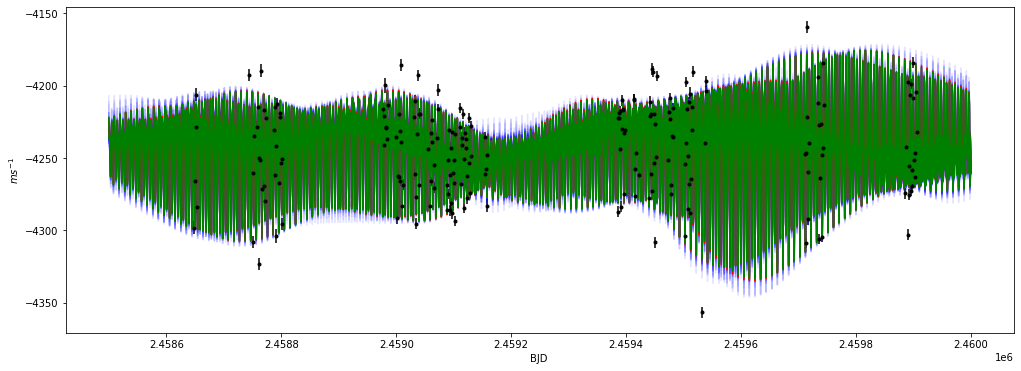

In [55]:
def Display(HyperParam, tplot):
    n1,n2,n3,n4, j = HyperParam
    
    kernel = kernels.QuasiPeriodic(n1,n2,n3,n4) + kernels.WhiteNoise(j)
    mean = means.Constant(np.mean(RV))
    gpOBJ = process.GP(kernel,mean,times_RV,RV,yerr = dRV)
    
    y_mean, y_std, time = gpOBJ.prediction(kernel,mean,tplot)
    return y_mean

plt.figure(figsize=(17, 6))


for s in range(25):
    plt.plot(tplot, Display(flat_samples[s,:], tplot), 'b', alpha=0.1)
Hfit = np.median(sampler.flatchain, axis=0)
GPrv = Display(Hfit, tplot)
plt.plot(tplot, GPrv, 'r')
BestFitRV = Display(sample_mlh, tplot)
plt.plot(tplot, BestFitRV, 'g')
plt.errorbar(times_RV, RV, yerr=dRV, fmt='k.')
plt.xlabel('BJD ')
plt.ylabel('$m s^{-1}$')
plt.show()

In [56]:
print('logLikelihood:', logPosterior(Hfit))

logLikelihood: -931.4853544998059


100%|██████████| 15/15 [00:02<00:00,  5.59it/s]


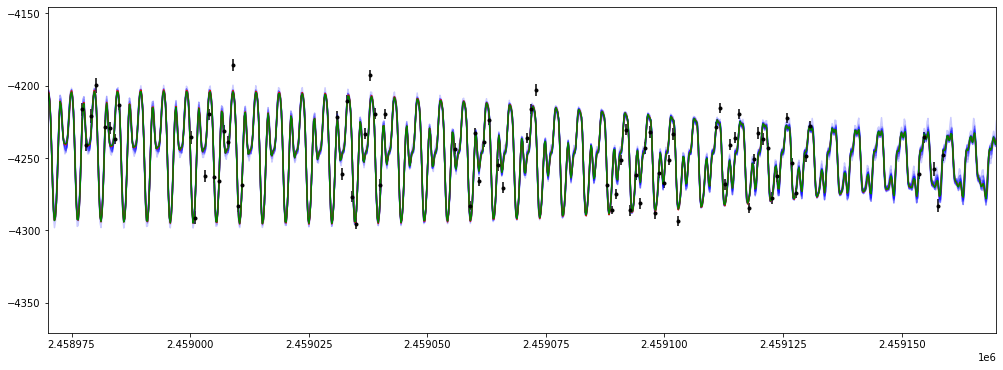

In [57]:
plt.figure(figsize=(17, 6))

tplot2 = np.linspace(-30+ 2459000,170+ 2459000, 1000)
 
for s in tqdm(range(15)):
    plt.plot(tplot2, Display(flat_samples[s,:], tplot2), 'b', alpha=0.2)
Hfit = np.median(sampler.flatchain, axis=0)
plt.plot(tplot2, Display(Hfit, tplot2), 'r')
plt.plot(tplot2, Display(sample_mlh, tplot2), 'g')
plt.errorbar(times_RV, RV, yerr=dRV, fmt='k.')
plt.xlim([-30 + 2459000,170 + 2459000])
plt.show()

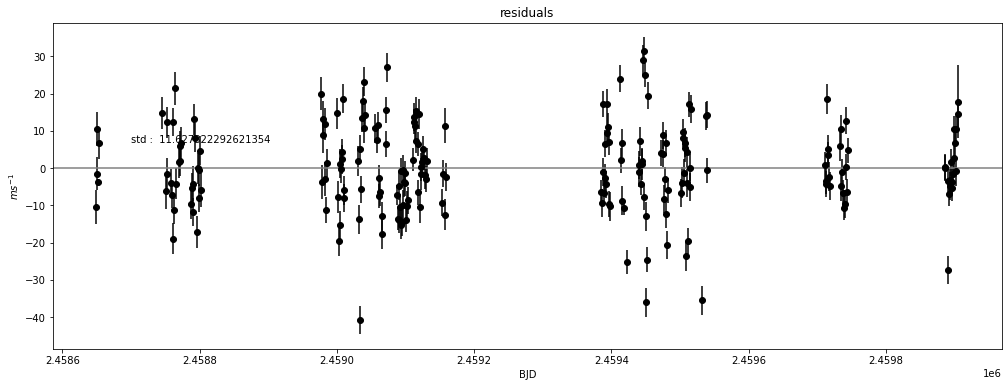

In [59]:
y_sample = Display(sample_mlh, times_RV)

residuals = RV - y_sample
plt.figure(figsize=(17, 6))
plt.errorbar(times_RV, residuals, yerr=dRV, fmt='ok')
plt.annotate( "std :  " + str(np.std(residuals)), (+ 2459000 -300, 7) )
plt.axhline(y=0, c='grey')
plt.title('residuals')
plt.xlabel('BJD')
plt.ylabel('$m s^{-1}$')
plt.show()

###  Correlations  Between GPs

In [60]:
print('RV X B :')
print(pearsonr(GPb, GPrv))
print(pearsonr(BestFitRV, BestFitB))
print('RV X W1 :')
print(pearsonr(GPrv, GPca))
print(pearsonr(BestFitRV, BestFitPCA))

RV X B :
(0.08816194973659347, 7.88244103273904e-05)
(0.08891173019016096, 6.843701939220308e-05)
RV X W1 :
(-0.009346857367421498, 0.6761284736917218)
(-0.009348769894136095, 0.6760659685332566)


### first derivative correlations 

In [61]:
GP_Bp = np.gradient(GPb, tplot)
GP_Wp = np.gradient(GPca, tplot)

BFBp = np.gradient(BestFitB, tplot)
BFPCAp = np.gradient(BestFitPCA, tplot)

In [62]:
print('RV X dB/dt :')
print(pearsonr(GP_Bp, GPrv))
print(pearsonr(BFBp, BestFitRV))
print('RV X dW1/dt :')
print(pearsonr(GPrv, GP_Wp))
print(pearsonr(BFPCAp, BestFitRV))

RV X dB/dt :
(0.8772558534499202, 0.0)
(0.8747072511576233, 0.0)
RV X dW1/dt :
(-0.9223557162595722, 0.0)
(-0.9221002840781689, 0.0)
